# **Convolutional Neural Network**

In this lesson we will cover Neural Networks using the Sequential model. We will also build sequential models and Convolutional Neural Networks commonly used for image classification. First we will build an image classifier using dense layers only, then we will enhace the model by adding convolutional layers. Later we will use a pre-trained model and also tune the model.This lesson was taken from the book [Deep Learning with Python](https://learning.oreilly.com/library/view/deep-learning-with/9781617294433/OEBPS/Text/05.xhtml).

In [1]:
import numpy as np
import os

# model
import tensorflow as tf
from keras.models import Sequential

# layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten

# pretarined model
from keras.applications import VGG16

# kekeras.applicationss
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard


# visual stuffs
import matplotlib.pyplot as plt

2023-10-31 18:28:46.974819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/carlos/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%html
<img src='./images/Pixels.png', width=900, height=900>

[Image Source](https://learning.oreilly.com/library/view/python-machine-learning/9781787125933/ch15.html)

## Images

For the entire lesson we used the [Cats and Dogs](https://www.kaggle.com/c/dogs-vs-cats/data) dataset from Kaggle.

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation d

In [4]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


Found 2000 images belonging to 2 classes.


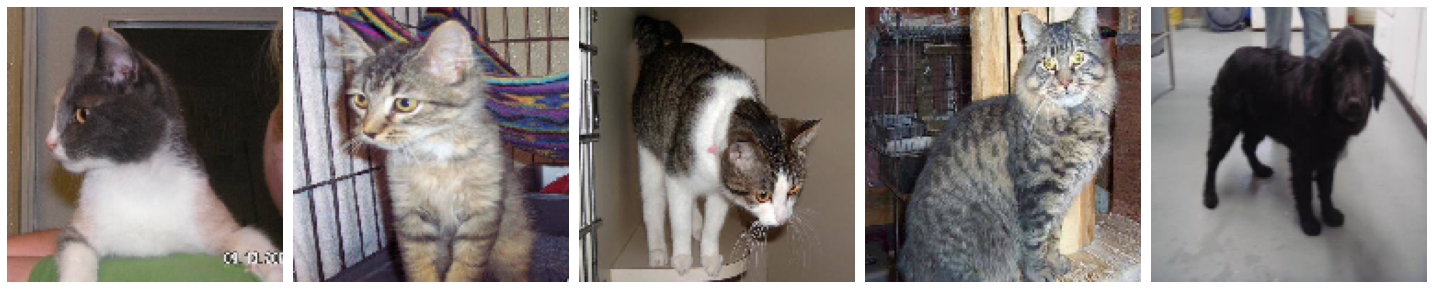

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_data_gen = train_image_generator.flow_from_directory(batch_size=20,
                                                           directory=train_dir,
                                                           classes=['dogs', 'cats'],
                                                           shuffle=True,
                                                           target_size=(150, 150),
                                                           class_mode='binary')


sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

## Image Classification with Dense Layers

As you may already know the neurons in a dense layer are not connected but are interconected with all neurons in prior and sud-sequent layers. Before proceeding into more detail I should first explain what python generators are why use generators to train neural networks.

In [8]:
%%html
<img src='../Week6_4.23/Multi_NN.png', width=700, height=700>

### Python Generators

In [9]:
def make_list(nums):
    
    my_list = [num for num in range(nums)]
    
    return my_list
    

In [10]:
my_list = make_list(5)

In [11]:
my_list

[0, 1, 2, 3, 4]

In [12]:
for i in my_list:
    print(i)

0
1
2
3
4


In [13]:
def make_generator(nums):
    
    for num in range(nums):
        yield num

In [14]:
make_gen = make_generator(5)

In [15]:
make_gen

<generator object make_generator at 0x7fa00cceb660>

In [16]:
for i in make_gen:
    print(i)

0
1
2
3
4


In [17]:
for i in make_gen:
    print(i)

In [18]:
make_gen = make_generator(10)

In [19]:
for i in make_gen:
    print(i)

0
1
2
3
4
5
6
7
8
9


In [20]:
for i in make_gen:
    print(i)

### Preparing the Data

In [22]:
train_gen = ImageDataGenerator(rescale=1/255)
test_gen = ImageDataGenerator(rescale=1/255)

In [23]:
train_generator = train_gen.flow_from_directory(
                    train_dir, 
                    target_size=(150, 150), 
                    batch_size=20,
                    classes=['dogs', 'cats'],
                    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [24]:
valid_generator = test_gen.flow_from_directory(
                    validation_dir, 
                    target_size=(150, 150), 
                    batch_size=20,
                    classes=['dogs', 'cats'],
                    class_mode='binary')

Found 1000 images belonging to 2 classes.


### Dense Layers Model

In [25]:
model_seq = Sequential()

model_seq.add(Dense(200, input_shape=(150, 150, 3), activation='relu'))
model_seq.add(Dense(200, activation='relu'))
model_seq.add(Flatten())
model_seq.add(Dense(1, activation='sigmoid'))

model_seq.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [26]:
150*150*200

4500000

In [27]:
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150, 150, 200)     800       
                                                                 
 dense_1 (Dense)             (None, 150, 150, 200)     40200     
                                                                 
 flatten (Flatten)           (None, 4500000)           0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4500001   
                                                                 
Total params: 4541001 (17.32 MB)
Trainable params: 4541001 (17.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_seq.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=10, 
    validation_data=valid_generator, 
    validation_batch_size=10,
)

Epoch 1/10
10/10 [==============================] - 24s 2s/step - loss: 1.4109 - acc: 0.5750 - val_loss: 0.7538 - val_acc: 0.5000
Epoch 2/10
10/10 [==============================] - 23s 3s/step - loss: 0.6963 - acc: 0.5400 - val_loss: 0.6815 - val_acc: 0.5670
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6777 - acc: 0.5650

## Convolutional Neural Network (CNN)

Convolutional layers can be considered as filters that extract the important features from an image. Compared to dense layers, convolutional layers share the weights within a single layer. Convolutional layers work by first taking small patches then taking dot product of the patch and a kernel filter. After each convolution the heigh and width of the image will shrink while the numbers of channels will increase. A simple explanation of how CNN work can be found [here](https://www.youtube.com/watch?v=x_VrgWTKkiM). More detailed explanation are found [here](https://learning.oreilly.com/videos/understanding-convolutional-neural/9781491978931/9781491978931-video312598).

In [26]:
%%html
<img src='./images/CNN.png', width=500, height=500>

In [27]:
%%html
<img src='./images/Pooling.png', width=700, height=700>

[Image Source](https://learning.oreilly.com/library/view/python-machine-learning/9781787125933/ch15.html)

In [28]:
%%html
<img src='./images/CNNFC.png', width=1000, height=1000>

[Image Source](https://www.kdnuggets.com/2016/11/intuitive-explanation-convolutional-neural-networks.html/3)

In [29]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model_cnn.add(MaxPool2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPool2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPool2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(200, activation='relu'))
model_cnn.add(Dense(200, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [30]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

In [34]:
model_cnn.fit(
    train_generator, 
    steps_per_epoch=10,  
    epochs=10, 
    validation_data=valid_generator, 
    validation_batch_size=10,
    workers=8
)

Epoch 1/10
10/10 [==============================] - 8s 820ms/step - loss: 0.6854 - acc: 0.5600 - val_loss: 0.6871 - val_acc: 0.5250
Epoch 2/10
10/10 [==============================] - 8s 830ms/step - loss: 0.6830 - acc: 0.5550 - val_loss: 0.6828 - val_acc: 0.5760
Epoch 3/10
10/10 [==============================] - 8s 806ms/step - loss: 0.6846 - acc: 0.5550 - val_loss: 0.6984 - val_acc: 0.4980
Epoch 4/10
10/10 [==============================] - 7s 717ms/step - loss: 0.6973 - acc: 0.4850 - val_loss: 0.6825 - val_acc: 0.5950
Epoch 5/10
10/10 [==============================] - 6s 649ms/step - loss: 0.6827 - acc: 0.5850 - val_loss: 0.6824 - val_acc: 0.5820
Epoch 6/10
10/10 [==============================] - 6s 654ms/step - loss: 0.6807 - acc: 0.5550 - val_loss: 0.6806 - val_acc: 0.5880
Epoch 7/10
10/10 [==============================] - 6s 648ms/step - loss: 0.6801 - acc: 0.5450 - val_loss: 0.6828 - val_acc: 0.5710
Epoch 8/10
10/10 [==============================] - 6s 640ms/step - loss: 0.

## CNN with Data Augmentation

In [35]:
%%html
<img src='./images/Dog_augmented.png', width=900, height=900>

In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [45]:
train_generator = train_datagen.flow_from_directory(
        train_dir,                                          
        target_size=(150, 150),                             
        batch_size=32,
        shuffle=True,
        class_mode='binary'
) 

Found 2000 images belonging to 2 classes.


In [46]:
model_cnn_aug = Sequential()

model_cnn_aug.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model_cnn_aug.add(MaxPool2D((2, 2)))
model_cnn_aug.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_aug.add(MaxPool2D((2, 2)))
model_cnn_aug.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn_aug.add(MaxPool2D((2, 2)))
model_cnn_aug.add(Flatten())
model_cnn_aug.add(Dense(200, activation='relu'))
model_cnn_aug.add(Dense(200, activation='relu'))
model_cnn_aug.add(Dense(1, activation='sigmoid'))

model_cnn_aug.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [47]:
model_cnn_aug.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=10, 
    validation_data=valid_generator, 
    validation_batch_size=10,
    workers=42
)

Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 0.6939 - acc: 0.4656 - val_loss: 0.6940 - val_acc: 0.4820
Epoch 2/10
10/10 [==============================] - 8s 739ms/step - loss: 0.6940 - acc: 0.4812 - val_loss: 0.6923 - val_acc: 0.5000
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 0.6934 - acc: 0.5033 - val_loss: 0.6932 - val_acc: 0.4960
Epoch 4/10
10/10 [==============================] - 8s 737ms/step - loss: 0.6922 - acc: 0.5188 - val_loss: 0.6920 - val_acc: 0.5260
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 0.6901 - acc: 0.5688 - val_loss: 0.6962 - val_acc: 0.5000
Epoch 6/10
10/10 [==============================] - 8s 753ms/step - loss: 0.6952 - acc: 0.4719 - val_loss: 0.6920 - val_acc: 0.5400
Epoch 7/10
10/10 [==============================] - 9s 819ms/step - loss: 0.6927 - acc: 0.5250 - val_loss: 0.6912 - val_acc: 0.5060
Epoch 8/10
10/10 [==============================] - 9s 850ms/step - loss: 0.6907 -

## Fine Tunning a pre-Trained Model-VGG16

For small datasets we can use a pre-trained machine learning model and attach a fully connected dense layers at the top to enhance the task. Keras does provide with a set of pre-trained models, [Keras pre-trained CNN](https://keras.io/applications/). For this lesson we will use VGG 16 model.


In [48]:
vgg = VGG16(weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3))

In [49]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [50]:
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [51]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [52]:
model_vgg = Sequential()

model_vgg.add(vgg)
model_vgg.add(Flatten())
model_vgg.add(Dense(200, activation='relu'))
model_vgg.add(Dense(200, activation='relu'))
model_vgg.add(Dense(1, activation='sigmoid'))

model_vgg.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [53]:
model_vgg.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_15 (Dense)            (None, 200)               1638600   
                                                                 
 dense_16 (Dense)            (None, 200)               40200     
                                                                 
 dense_17 (Dense)            (None, 1)                 201       
                                                                 
Total params: 16393689 (62.54 MB)
Trainable params: 8758425 (33.41 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [55]:
tensorboard = TensorBoard(
  log_dir='./logs',
  histogram_freq=1,
  write_images=True
)

In [56]:
model_vgg.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=10, 
    validation_data=valid_generator, 
    callbacks=[tensorboard]
)

Epoch 1/10
10/10 [==============================] - 78s 8s/step - loss: 0.7466 - acc: 0.5250 - val_loss: 0.6300 - val_acc: 0.7300
Epoch 2/10
10/10 [==============================] - 87s 9s/step - loss: 0.6285 - acc: 0.6531 - val_loss: 0.5841 - val_acc: 0.6930
Epoch 3/10
10/10 [==============================] - 81s 9s/step - loss: 0.6397 - acc: 0.6217 - val_loss: 0.6159 - val_acc: 0.5890
Epoch 4/10
10/10 [==============================] - 85s 9s/step - loss: 0.5777 - acc: 0.6844 - val_loss: 0.4734 - val_acc: 0.7760
Epoch 5/10
10/10 [==============================] - 88s 9s/step - loss: 0.5840 - acc: 0.7656 - val_loss: 0.4109 - val_acc: 0.8530
Epoch 6/10
10/10 [==============================] - 82s 9s/step - loss: 0.6293 - acc: 0.6844 - val_loss: 0.4151 - val_acc: 0.8550
Epoch 7/10
10/10 [==============================] - 83s 9s/step - loss: 0.4551 - acc: 0.8031 - val_loss: 0.7321 - val_acc: 0.6320
Epoch 8/10
10/10 [==============================] - 83s 9s/step - loss: 0.5983 - acc: 0.69

In [57]:
model_vgg.evaluate(train_generator)

63/63 [==============================] - 116s 2s/step - loss: 0.3642 - acc: 0.8580


[0.36419352889060974, 0.8579999804496765]

In [58]:
train_predictions = model_vgg.predict(train_generator)

63/63 [==============================] - 117s 2s/step


In [61]:
train_predictions

array([[0.48672625],
       [0.65201986],
       [0.12543902],
       ...,
       [0.83048385],
       [0.31148002],
       [0.6165629 ]], dtype=float32)

In [62]:
model_vgg.evaluate(valid_generator)

50/50 [==============================] - 50s 1s/step - loss: 0.3040 - acc: 0.8720


[0.30402258038520813, 0.871999979019165]

In [ ]:
%load_ext tensorboard
%tensorboard -- logdirs

## Fine tunning VGG16 in Kaggle Kernel, [here](https://www.kaggle.com/carlosezmez/cnn-cuny-tech-prep/edit)